### Parallel simulations

In [1]:
import numpy as np

In [2]:
from dask_quantumtinkerer import Cluster, cluster_options

In [3]:
from codes.parallel import optimize_phase_voltage

VoronoiMesh version 0.1
DiscretePoisson version 0.3
Shape version: 0.1
SystEquations version: 0.3
Solver version 0.1


In [4]:
options = cluster_options()
options.worker_cores = 2
options.worker_memory = 10
options.extra_path = "/home/srangaswamykup/trijunction-design/"
cluster_dashboard_link = "http://io.quantumtinkerer.tudelft.nl/user/srangaswamykup/proxy/"

In [5]:
thickness = [0.5, 1.5]
channel_width = [11.0, 15.0]
gap = [2.0]
angle = [np.pi/6]

In [6]:
from itertools import product

In [7]:
samples = list(product(thickness, channel_width, angle, gap))
samples = list(zip(range(len(samples)), samples)) # add identifier
samples = [[sample[0]] + list(sample[1])  for sample in samples] # unpack second index and make a single list

In [19]:
samples

[[0, 0.5, 11.0, 0.5235987755982988, 1.0],
 [1, 0.5, 11.0, 0.5235987755982988, 3.0],
 [2, 0.5, 15.0, 0.5235987755982988, 1.0],
 [3, 0.5, 15.0, 0.5235987755982988, 3.0],
 [4, 1.5, 11.0, 0.5235987755982988, 1.0],
 [5, 1.5, 11.0, 0.5235987755982988, 3.0],
 [6, 1.5, 15.0, 0.5235987755982988, 1.0],
 [7, 1.5, 15.0, 0.5235987755982988, 3.0]]

In [8]:
import codes.parallel
import importlib
importlib.reload(codes.parallel)

<module 'codes.parallel' from '/home/tinkerer/trijunction-design/analysis/codes/parallel.py'>

In [17]:
samples

[[0, 0.5, 11.0, 0.5235987755982988, 1.0],
 [1, 0.5, 11.0, 0.5235987755982988, 3.0],
 [2, 0.5, 15.0, 0.5235987755982988, 1.0],
 [3, 0.5, 15.0, 0.5235987755982988, 3.0],
 [4, 1.5, 11.0, 0.5235987755982988, 1.0],
 [5, 1.5, 11.0, 0.5235987755982988, 3.0],
 [6, 1.5, 15.0, 0.5235987755982988, 1.0],
 [7, 1.5, 15.0, 0.5235987755982988, 3.0]]

#### Adaptive sampling

In [1]:
import tinyarray as ta
import numpy as np
import matplotlib.pyplot as plt
import importlib
import json
import kwant
from dask_quantumtinkerer import Cluster, cluster_options
import adaptive

import codes.trijunction as trijunction
import codes.optimization as optimization
import codes.parameters as parameters
from codes.system_functions import diagonalisation, adaptive_two_parameters
from codes.tools import hamiltonian
from codes.utils import eigsh, svd_transformation, dict_update, dep_acc_index, order_wavefunctions

VoronoiMesh version 0.1
DiscretePoisson version 0.3
Shape version: 0.1
SystEquations version: 0.3
Solver version 0.1


In [2]:
pairs = ['right-top', 'left-top', 'left-right']

In [3]:
from scipy.optimize import minimize, minimize_scalar

In [4]:
with open('/home/tinkerer/trijunction-design/codes/config.json', 'r') as f:
    config = json.load(f)

change_config = [
      {"device":
     {"grid_spacing":
      {"twoDEG": 0.5, "normal": 1, "dielectric": 1, "air": 5, "gate": 1, "substrate": 1}}},
    {"gate": {"channel_width": 13.0, "L":40, 'angle': np.pi/6, 'gap': 4}},
    # {"kwant": {'nww': 8}}
]

for local_config in change_config:
    config = dict_update(config, local_config)

In [5]:
system = trijunction.Trijunction(config, optimize_phase_pairs=[])

Finding closed voronoi cells
Done selecting closed voronoi cells
Calculating points distance
Done
Calculating ridges hypersurfaces
Done
Finding  hypervolume for closed voronoi cells
Done finding hypervolume for closed voronoi cells
Done calculating surface
Done calculating distance
Done calculating capacitance matrix


100%|██████████| 13/13 [00:30<00:00,  2.34s/it]


# Phase exploration 

In [6]:
options = cluster_options()
options.worker_cores = 2
options.worker_memory = 2
options.extra_path = "/home/srangaswamykup/trijunction-design/"

In [7]:
# prepare arguments
phis = np.linspace(0, 2, 50) * np.pi
phases = {}

for pair in pairs:
    phases[pair] = [parameters.phase_pairs(pair, phi) for phi in phis]

In [23]:
voltages = parameters.pair_voltages(initial=(-3.3e-3, -3.3e-3, -3.3e-3, 3e-2), 
                                    depleted=-7e-3)

In [24]:
# fixed voltage matrices
fixed_linear_matrices = [
    sum(
        [volts[key] * system.linear_terms[key] for key in system.linear_terms.keys()]
    ) for volts in voltages.values()
]

In [25]:
cluster_dashboard_link = "http://io.quantumtinkerer.tudelft.nl/user/srangaswamykup/proxy/"
params = parameters.junction_parameters()
params.update(potential=system.flat_potential())

with Cluster(options) as cluster:
    cluster.scale(n=50)
    client = cluster.get_client()
    client.wait_for_workers(1)
    print(cluster_dashboard_link + cluster.dashboard_link[17:])
    scattered_trijunction = client.scatter(system.trijunction, broadcast=True)
    scattered_f_params = client.scatter(system.f_params, broadcast=True)
    scattered_linear_terms = client.scatter(fixed_linear_matrices, broadcast=True)

    for i, pair in enumerate(pairs):
        futures = client.map(
            diagonalisation,
            phases[pair],
            trijunction=scattered_trijunction,
            f_params=scattered_f_params,
            linear_terms=scattered_linear_terms[i],
            params=params
        )
        phase_relations[pair] = client.gather(futures)

http://io.quantumtinkerer.tudelft.nl/user/srangaswamykup/proxy/8000/clusters/d03eb39d26b840509032448e774cf8cc/status


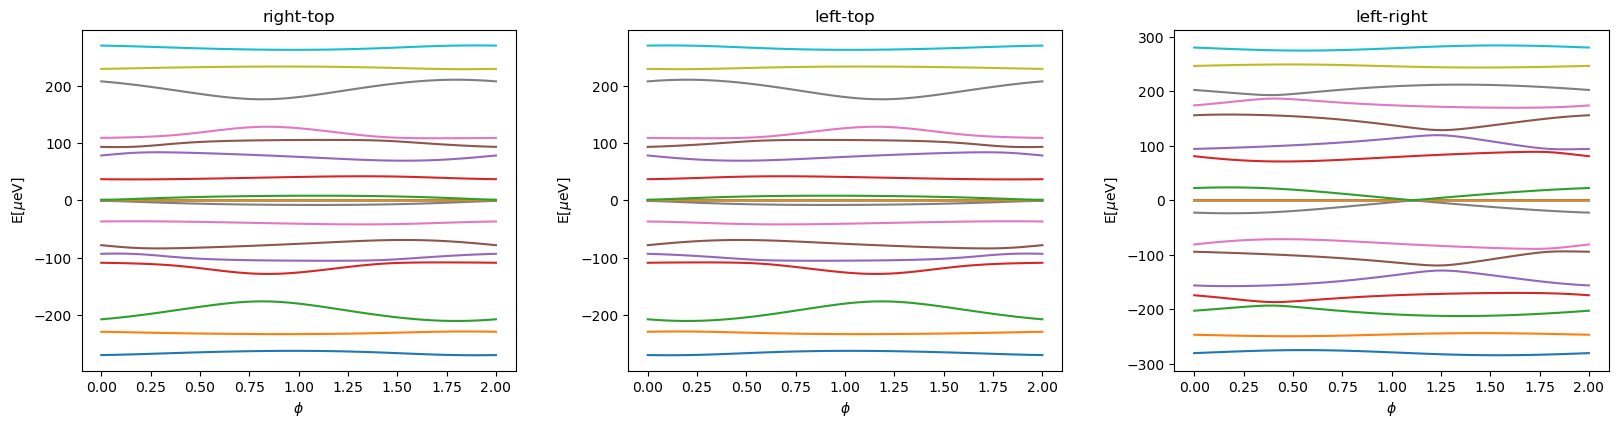

In [27]:
fig, axes = plt.subplots(ncols=3, figsize=(16, 4))
fig.tight_layout(w_pad=5)

for i, pair in enumerate(pairs):

    phase = 1e6*np.array(phase_relations[pair])

    axes[i].set_title(pair)
    axes[i].set_xlabel(r'$\phi$')
    axes[i].set_ylabel(r'E[$\mu$eV]')

    axes[i].plot(phis/np.pi, phase)
    # opt_phase = list(list(optimal_phases.values())[i].values())[0]
    # axes[i].vlines(opt_phase, ymin=-np.max(phase), ymax=np.max(phase))

## Voltage exploration 

In [28]:
plunger_min = -5e-3
plunger_max = 0

bounds = [
    (plunger_min, plunger_max),
    (plunger_min, plunger_max),
]

In [ ]:
params = parameters.junction_parameters()
params.update(potential=system.flat_potential())

index = system.indices.copy()

# remove 50% of the points from the channel to be depleted that is closest to the center.
depleted_channel = list(set(sides)-set(pair.split('-')))[0]
depleted_indices = index[depleted_channel]
index[depleted_channel]  = depleted_indices[:int(len(depleted_indices)*50/100)]

params['dep_acc_index'] = index

args = (pair.split('-'),
        (system.base_ham, system.linear_terms),
        params['dep_acc_index'], 
        )

initial_condition = (-3e-3, -3e-3, -3e-3, 3e-3)

sol1 = minimize(codes.optimization.shape_loss, 
         x0=initial_condition, 
         args=args, 
         method='trust-constr', 
         options={'initial_tr_radius':1e-3}
        )

print(sol1.x)



def call_loss(pair, base_ham, base_params, linear_terms, f_params, mlwf):
    ci, wf_amp = 50, 1e-4
    args = ((base_ham, 
            base_params, 
            linear_terms, 
            f_params, 
             mlwf[order_wavefunctions(pair)]),
            (pair.split('-'), ci, wf_amp)
           )

In [43]:
cluster = await Cluster(options, asynchronous=True)

await cluster.scale(50)
client = await cluster.get_client()
await client.wait_for_workers(1)
print("http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/"+cluster.dashboard_link[17:])

http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/6eff509412214a50ae0fec1ddf813f3b/status


In [44]:
pair = 'right-top'

In [45]:
voltages = parameters.pair_voltages(initial=(-1.0e-3, -1.0e-3, -1.0e-3, 0), depleted=-7e-3)

In [46]:
params = parameters.junction_parameters()
params.update(potential=zero_potential)
base_ham = system.trijunction.hamiltonian_submatrix(sparse=True, params=system.f_params(**params))

In [47]:
scattered_base_ham = await client.scatter(base_ham, broadcast=True)
scattered_linear_matrices = await client.scatter(system.linear_terms, broadcast=True)

In [48]:
async def f_async(xy):
    future = client.submit(
        adaptive_two_parameters,
        xy,
        trijunction=scattered_base_ham,
        linear_terms=scattered_linear_matrices,
        keys=('top', 'right'),
        params=voltages[pair]
    )

    return await future

In [49]:
learner = adaptive.Learner2D(f_async, bounds=bounds)

In [50]:
runner = adaptive.AsyncRunner(
    learner,
    goal=lambda l: l.loss() < 0.001,
    ntasks=199
)

In [55]:
_, _, z = learner.interpolated_on_grid()

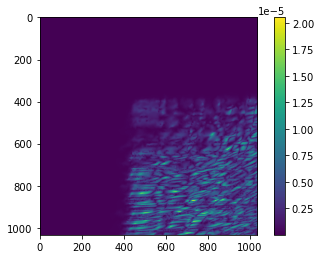

In [56]:
plot = plt.imshow(z)
plt.colorbar(plot)